In [1]:
import os
from pymongo import MongoClient
import pandas as pd
import numpy as np
%matplotlib inline

# Open MongoDBB

In [2]:
year = 2017

In [3]:
uri = "mongodb://mongo/tweets"
client = MongoClient(uri)

print( 'List of databases in MongoDB:' )
print(client.list_database_names())

# database
db = client['irs990']

# collection
dbYear = db['%s' % year]

List of databases in MongoDB:
['admin', 'config', 'irs990', 'local']


# Filter IRS Forms w/no Website

In [4]:
dbYear.delete_many({'$or':[{ 'WebsiteAddressTxt' : 'N/A' },{ 'WebsiteAddressTxt' : 'NONE' },{'WebsiteAddressTxt':{'$exists':bool(0)}}]})

# Feature Analysis

In [5]:
from bson.code import Code

In [6]:
map = Code("function() {"
    "for (var key in this) { emit(key, 1); }"
  "}");

reduce = Code("function(key, stuff) { var sum=0;for(var i in stuff) sum += stuff[i];"
     "return sum;}");

result = dbYear.map_reduce(map, reduce, "fieldResults")

In [7]:
d = {}
for doc in result.find():
    d[doc['_id']]= doc['value']
    
v_sorted = [d[key] for key in sorted(d, key=d.get, reverse=True)]
k_sorted = [key for key in sorted(d, key=d.get, reverse=True)]

The top aprox 150 Fields are rather consistent across the Collection

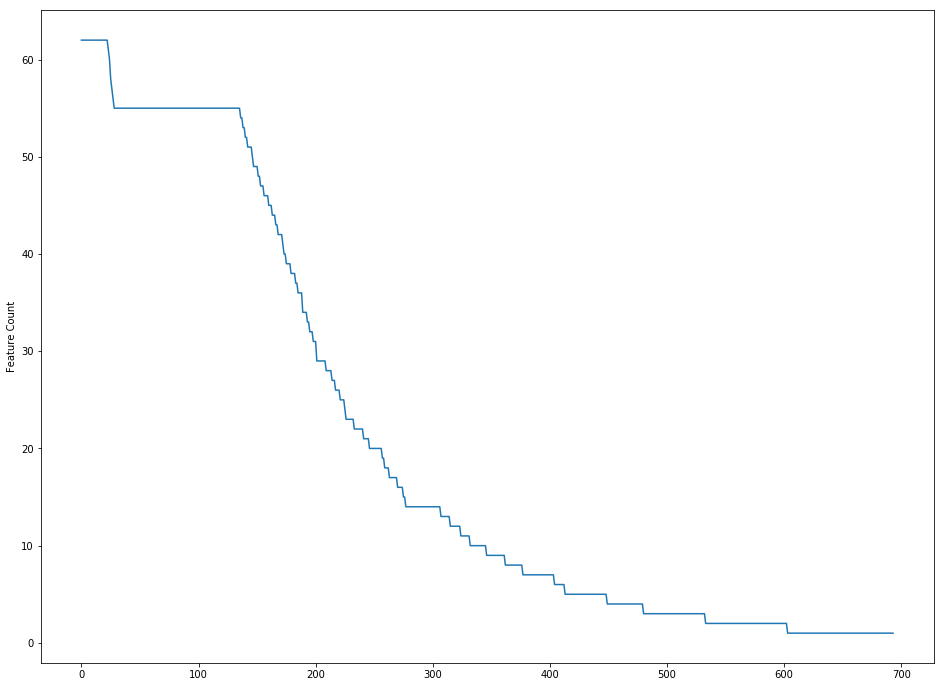

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 12))
plt.plot(v_sorted)
plt.ylabel("Feature Count")
plt.show()

In [9]:
top50 = k_sorted[:50]

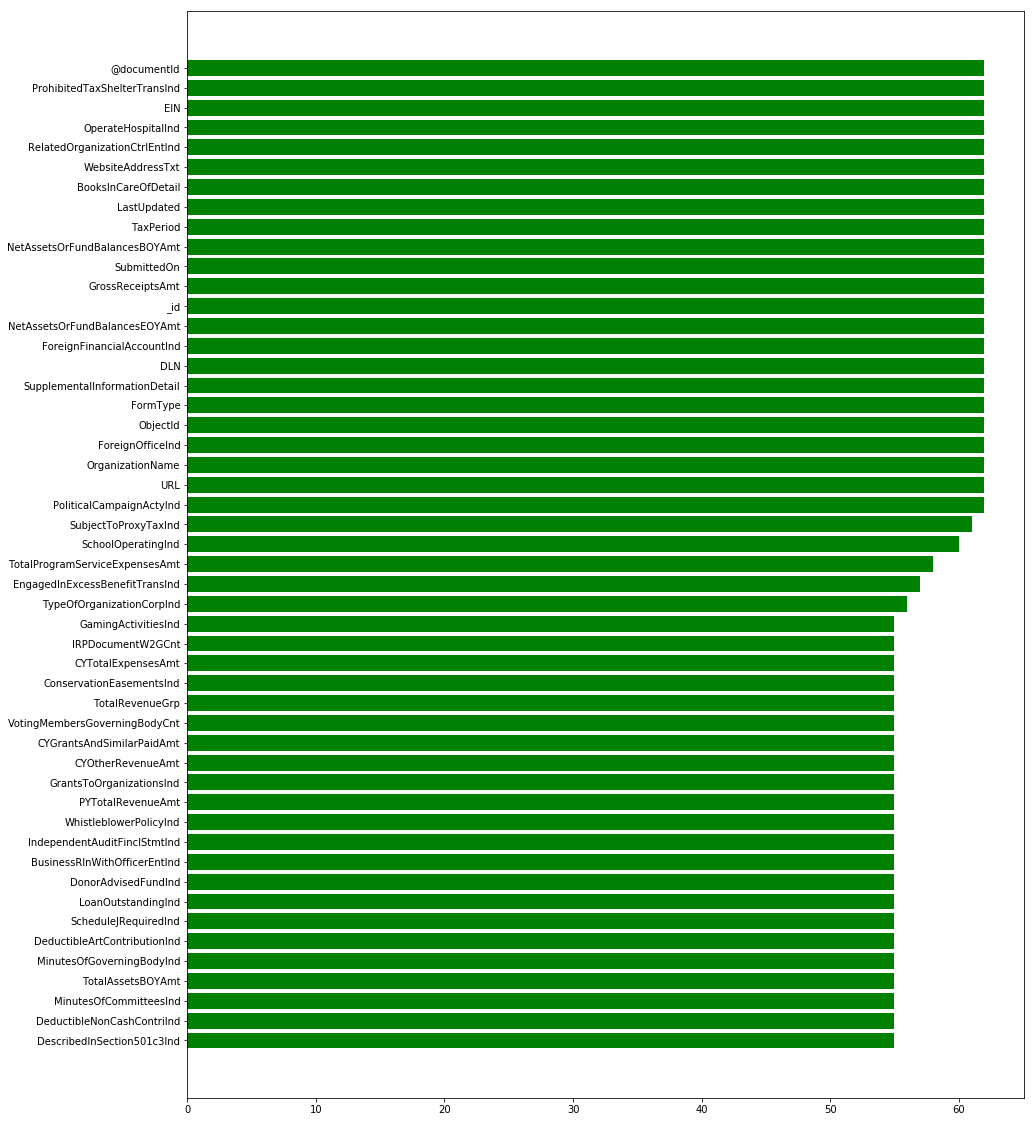

In [10]:
figure(figsize=(15, 20))
pos = np.arange(len(top50))
ax = plt.axes()
ax.invert_yaxis()  # labels read top-to-bottom
plt.barh(top50, v_sorted[:50], color='g',align='center')
plt.show()

# Filtering of Fields

In [11]:
cursor = dbYear.find({},{'OrganizationNAME':1, 'WebsiteAddressTxt':1,'Desc':1,'ActivityOrMissionDesc':1,
'USAddress.ZIPCd':1,'TaxExemptBondsInd':1,'EmployeeCnt':1,'CYTotalRevenueAmt':1,'CYTotalExpensesAmt':1,
'NetAssetsOrFundBalancesEOYAmt':1,'URL':1,'TaxPeriod':1,'LastUpDated':1,'FormType':1,'EIN':1,'GrossReceiptsAmt':1,'_id':0})

In [12]:
df = pd.DataFrame(list(cursor))

In [13]:
list(df.FormType.unique())

['990', '990EZ']

In [14]:
#Split by Form Type
df_990 = df[df['FormType']=='990']
df_990EZ = df[df['FormType']=='990EZ']

In [15]:
df_990

,ActivityOrMissionDesc,CYTotalExpensesAmt,CYTotalRevenueAmt,Desc,EIN,EmployeeCnt,FormType,GrossReceiptsAmt,NetAssetsOrFundBalancesEOYAmt,TaxExemptBondsInd,TaxPeriod,URL,USAddress,WebsiteAddressTxt
0,TO DEVELOP AFFORDABLE RENTAL AND OWNERSHIP HOU...,2880329,3413572,COMMUNITY SERVICES: WORKS WITH COMMUNITY MEMBE...,042964630,25,990,3419944,2962890,0,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '02128'},WWW.NOAHCDC.ORG
1,"RELEAF MICHIGAN, INC. ASSISTS COMMUNITIES IN T...",71328,98045,TREES AND SEEDLINGS WERE PLANTED IN COOPERATIO...,382912028,1,990,133367,9583,false,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '48103'},RELEAFMICHIGAN.ORG
2,SUPPORT FOR FAMILY AND FRIENDS OF MENTALLY ILL...,162576,184360,SUPPORT GROUP FOR FAMILY AND FRIENDS OF MENTAL...,202699020,3,990,222014,163528,false,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '62269'},WWW.KARLASMITHFOUNDATION.ORG
3,Creation of a revolving loan fund.,806159,653283,Creation of a revolving loan fund for low inte...,251525572,0,990,653283,1200323,0,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '16510'},www.developerie.com
4,TO FACILITATE THE GRANT FUNDED BY THE NEW JERS...,564347,494830,GRANT - EMERGENCY MANAGEMENT THE OVERARCHING R...,810593280,0,990,494830,135697,false,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '08691'},WWW.HCANJ.ORG
7,To provide child care and tutoring services,301484,302603,Child care,204212837,0,990,302603,-92747,false,201512,https://s3.amazonaws.com/irs-form-990/20161244...,{'ZIPCd': '45404'},www.greatergalileelearningcenter.com
8,To provide education for Alabama probate judge...,138953,180085,The association provides educational programs ...,631282125,0,990,180085,432561,0,201512,https://s3.amazonaws.com/irs-form-990/20161244...,{'ZIPCd': '36867'},http://www.alabamaprobatejudges.org
9,"OUR MISSION IS TO GATHER, PRESERVE AND DISSEMI...",258898,244437,THE ACHS GATHERED THE STORIES AND ARTIFACTS OF...,411375036,11,990,253140,834907,false,201512,https://s3.amazonaws.com/irs-form-990/20161244...,NaN,WWW.ANOKACOUNTYHISTORY.ORG
10,TO PROVIDE SUPPORT TO THE PROGRAMS OF THE MT D...,161939,50497,THE ORGANIZATION PROVIDED SUPPORT TO THE PROGR...,946181807,0,990,50497,7654901,0,201512,https://s3.amazonaws.com/irs-form-990/20161244...,{'ZIPCd': '94523'},www.bsa-mdsc.org
11,MAKING THE WEST AND RHODE RIVERS AND THEIR WAT...,511739,446786,MONITORING OF THE WEST AND RHODE RIVERS AND TH...,412164361,6,990,451842,54777,false,201512,https://s3.amazonaws.com/irs-form-990/20161244...,{'ZIPCd': '20764'},WWW.WESTRHODERIVERKEEPER.ORG


In [16]:
df_990EZ

,ActivityOrMissionDesc,CYTotalExpensesAmt,CYTotalRevenueAmt,Desc,EIN,EmployeeCnt,FormType,GrossReceiptsAmt,NetAssetsOrFundBalancesEOYAmt,TaxExemptBondsInd,TaxPeriod,URL,USAddress,WebsiteAddressTxt
5,NaN,NaN,NaN,NaN,510183497,NaN,990EZ,40833,32904,NaN,201512,https://s3.amazonaws.com/irs-form-990/20161244...,NaN,CARRIAGETRAVELCLUB.COM
6,NaN,NaN,NaN,NaN,273276308,NaN,990EZ,86876,93492,NaN,201512,https://s3.amazonaws.com/irs-form-990/20161244...,NaN,GRIFFINFOODPANTRY.COM
14,NaN,NaN,NaN,NaN,546053668,NaN,990EZ,115877,8103,NaN,201606,https://s3.amazonaws.com/irs-form-990/20161245...,NaN,WWW.WILLIAMSBURGROTARY.ORG
15,NaN,NaN,NaN,NaN,270290159,NaN,990EZ,22968,25083,NaN,201512,https://s3.amazonaws.com/irs-form-990/20161245...,NaN,COMMONSENSEALLIANCE.NET
40,NaN,NaN,NaN,NaN,464014717,NaN,990EZ,47082,28622,NaN,201606,https://s3.amazonaws.com/irs-form-990/20161246...,NaN,FARMS.HARTLANDSCHOOLS.US/FIS-PTO
51,NaN,NaN,NaN,NaN,362837731,NaN,990EZ,38881,82397,NaN,201604,https://s3.amazonaws.com/irs-form-990/20161251...,NaN,WWW.EEAI.NET
58,NaN,NaN,NaN,NaN,010563744,NaN,990EZ,18558,10333,NaN,201512,https://s3.amazonaws.com/irs-form-990/20161252...,NaN,WWW.CORALGABLESPAL.COM
